# Energy Efficiency Analysis

This notebook is part of a midterm project of the [Machine Learning Zoomcamp](https://github.com/alexeygrigorev/mlbookcamp-code/tree/master/course-zoomcamp) course Cohort 2022. 	

In this project we evaluate the energy consumption of buildings by investigating the heating load requirements as a function of building parameters. It is a regression problem, so we tried the following models: Ridge(), DecisionTreeRegressor(), RandomForestRegressor() and XGBoost(). RMSE metric was used as an evaluation score during the model selection process.

This notebook contains Data preparation, Exploratory Data Analysis, Model selection process and Parameter tuning.

# Importing

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mutual_info_score
from sklearn.metrics import mean_squared_error

import xgboost as xgb;

import warnings
warnings.filterwarnings('ignore')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Data preparation and data clearning

In [2]:
df = pd.read_csv('energy_efficiency_data.csv')

In [3]:
df

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28
...,...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5,0.4,5,17.88,21.40
764,0.62,808.5,367.5,220.50,3.5,2,0.4,5,16.54,16.88
765,0.62,808.5,367.5,220.50,3.5,3,0.4,5,16.44,17.11
766,0.62,808.5,367.5,220.50,3.5,4,0.4,5,16.48,16.61


Input variables are: 
+ Relative_Compactness
+ Surface_Area - m²
+ Wall_Area - m²
+ Roof_Area - m²
+ Overall_Height - m
+ Orientation - 2:North, 3:South, 4:East, 5:West
+ Glazing_Area - 0%, 10%, 25%, 40%
+ Glazing_Area_Distribution - 0:No glasing, 1:Uniform, 2:North, 3:East, 4:South, 5:West

Output variable will be only: 
+ Heating_Load - kWh/m

We delete other output variable 'Cooling_Load'.

In [4]:
del df['Cooling_Load']

In [5]:
df.columns = df.columns.str.lower()
df.head()

,relative_compactness,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_distribution,heating_load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84


In [6]:
df.dtypes

relative_compactness         float64
surface_area                 float64
wall_area                    float64
roof_area                    float64
overall_height               float64
orientation                    int64
glazing_area                 float64
glazing_area_distribution      int64
heating_load                 float64
dtype: object

In [7]:
numerical = ['relative_compactness', 'surface_area', 'wall_area', 'roof_area', 'overall_height', 'glazing_area']
categorical = ['orientation', 'glazing_area_distribution']
target = 'heating_load'

Let's reformat categorical columns 'orientation' and 'glazing_area_distribution' by mapping with appropriate values.

In [8]:
orientation_values = {
    2:'north', 
    3:'south', 
    4:'east', 
    5:'west'
}
df.orientation = df.orientation.map(orientation_values)

glazing_area_distribution_values = {
    0:'no_glasing',
    1:'uniform', 
    2:'north', 
    3:'east', 
    4:'south', 
    5:'west'
}
df.glazing_area_distribution = df.glazing_area_distribution.map(glazing_area_distribution_values)

In [9]:
df.head()

,relative_compactness,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_distribution,heating_load
0,0.98,514.5,294.0,110.25,7.0,north,0.0,no_glasing,15.55
1,0.98,514.5,294.0,110.25,7.0,south,0.0,no_glasing,15.55
2,0.98,514.5,294.0,110.25,7.0,east,0.0,no_glasing,15.55
3,0.98,514.5,294.0,110.25,7.0,west,0.0,no_glasing,15.55
4,0.90,563.5,318.5,122.50,7.0,north,0.0,no_glasing,20.84


In [10]:
df.shape

(768, 9)

# Exploratory Data Analysis

- Data information
- Check for missing values
- Check for duplicated records
- Examination of statistics for each feature
- Visualization of the distribution of features
- Feature importance analysis

### Data Information

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   relative_compactness       768 non-null    float64
 1   surface_area               768 non-null    float64
 2   wall_area                  768 non-null    float64
 3   roof_area                  768 non-null    float64
 4   overall_height             768 non-null    float64
 5   orientation                768 non-null    object 
 6   glazing_area               768 non-null    float64
 7   glazing_area_distribution  768 non-null    object 
 8   heating_load               768 non-null    float64
dtypes: float64(7), object(2)
memory usage: 54.1+ KB


### Check for missing values

In [12]:
df.isnull().sum()

relative_compactness         0
surface_area                 0
wall_area                    0
roof_area                    0
overall_height               0
orientation                  0
glazing_area                 0
glazing_area_distribution    0
heating_load                 0
dtype: int64

### Check for duplicated records

In [13]:
df.duplicated().any()

False

### Examination of statistics for each feature

In [14]:
# statistics for numerical features
df.describe()

,relative_compactness,surface_area,wall_area,roof_area,overall_height,glazing_area,heating_load
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,0.234375,22.307201
std,0.105777,88.086116,43.626481,45.165950,1.75114,0.133221,10.090196
min,0.620000,514.500000,245.000000,110.250000,3.50000,0.000000,6.010000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,0.100000,12.992500
50%,0.750000,673.750000,318.500000,183.750000,5.25000,0.250000,18.950000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,0.400000,31.667500
max,0.980000,808.500000,416.500000,220.500000,7.00000,0.400000,43.100000


In [15]:
# range of values for each feature
for col in df.columns:
    print(f'Feature: `{col}`')
    print(f'Number of distinct elements: {df[col].nunique()}')
    print(df[col].unique()[:12])
    print()

Feature: `relative_compactness`
Number of distinct elements: 12
[0.98 0.9  0.86 0.82 0.79 0.76 0.74 0.71 0.69 0.66 0.64 0.62]

Feature: `surface_area`
Number of distinct elements: 12
[514.5 563.5 588.  612.5 637.  661.5 686.  710.5 735.  759.5 784.  808.5]

Feature: `wall_area`
Number of distinct elements: 7
[294.  318.5 343.  416.5 245.  269.5 367.5]

Feature: `roof_area`
Number of distinct elements: 4
[110.25 122.5  147.   220.5 ]

Feature: `overall_height`
Number of distinct elements: 2
[7.  3.5]

Feature: `orientation`
Number of distinct elements: 4
['north' 'south' 'east' 'west']

Feature: `glazing_area`
Number of distinct elements: 4
[0.   0.1  0.25 0.4 ]

Feature: `glazing_area_distribution`
Number of distinct elements: 6
['no_glasing' 'uniform' 'north' 'east' 'south' 'west']

Feature: `heating_load`
Number of distinct elements: 586
[15.55 20.84 21.46 20.71 19.68 19.5  19.95 19.34 18.31 17.05 17.41 16.95]



The data in the dataset were simulated, so the features have limited numbers of distinct elements and the artificial distributions as we can observe below.

### Visualization of the distribution of features

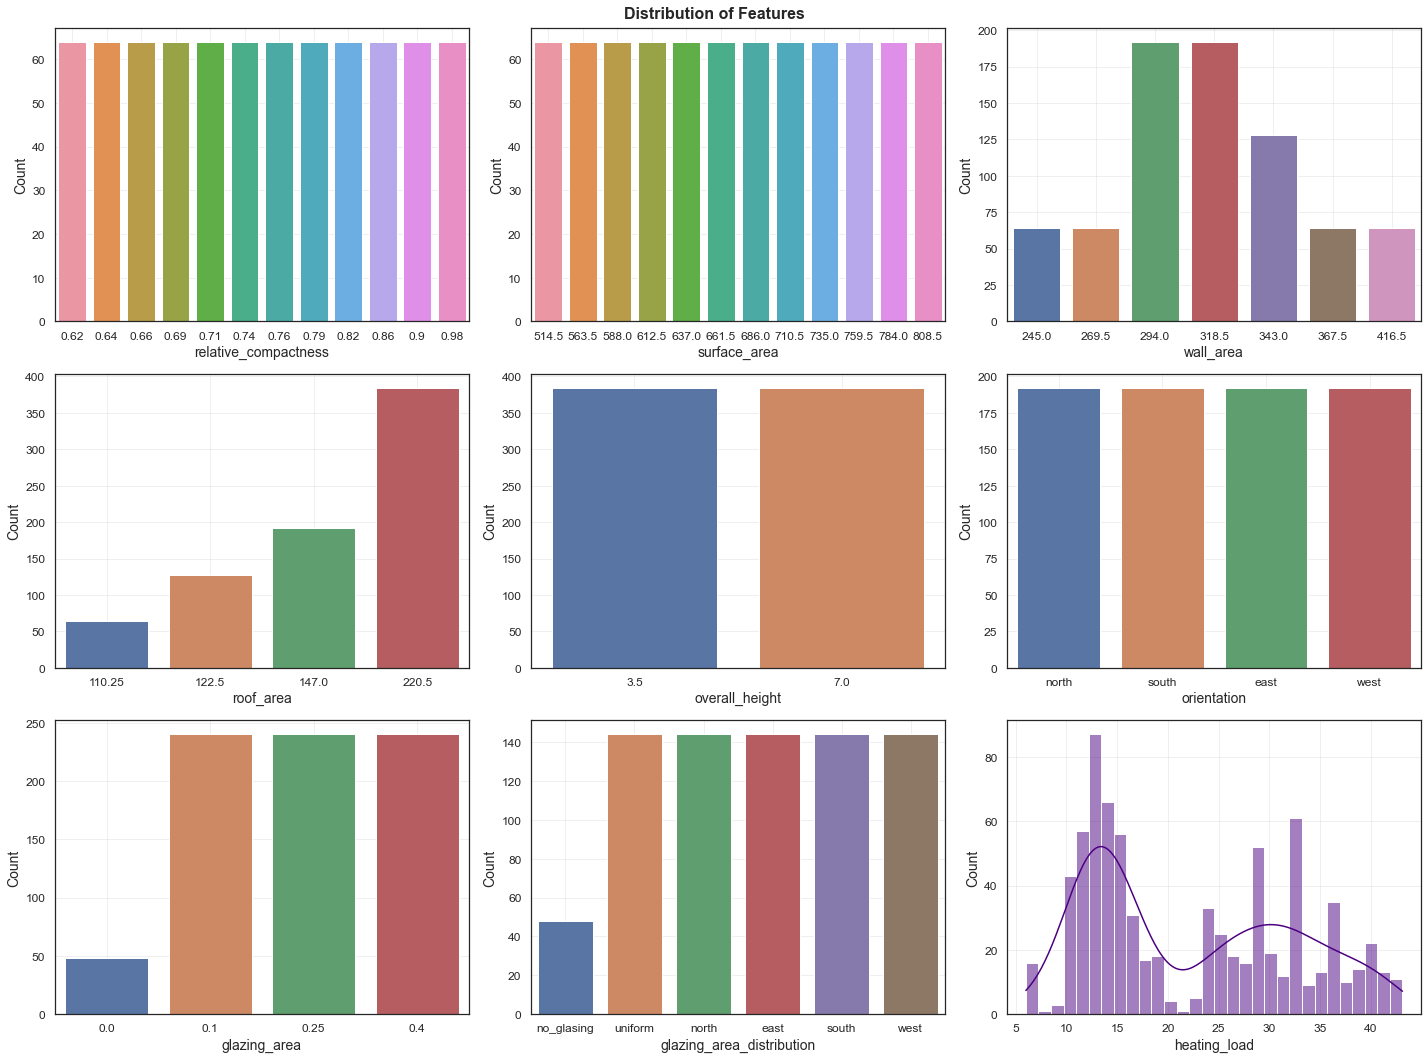

In [16]:
sns.set_theme(style="white")
fig, ax = plt.subplots(3, 3, figsize = (20,15))
plt.suptitle('Distribution of Features', fontsize = 16, fontweight = 'bold')
for index, column in enumerate(df.columns):
    i,j = ((index // 3), (index % 3))
    if not(i==2 and j==2):
        sns.countplot(data=df, x=column, ax=ax[i, j])
        ax[i, j].grid(alpha = 0.3)
        ax[i, j].tick_params(labelsize=12)
        ax[i, j].set_xlabel(column, fontsize=14)
        ax[i, j].set_ylabel('Count', fontsize=14)
    else:
        sns.histplot(df.heating_load, kde=True, bins=30, color='indigo', ax=ax[i, j])
        ax[i, j].grid(alpha = 0.3)
        ax[i, j].tick_params(labelsize=12)
        ax[i, j].set_xlabel(column, fontsize=14)
        ax[i, j].set_ylabel('Count', fontsize=14)
    
plt.tight_layout()
plt.show()

We noticed that the target feature 'heating_load' has a bimodal distribution. We assume that is was caused by two values of 'overall_height' feature. 

Let's check this assumption:

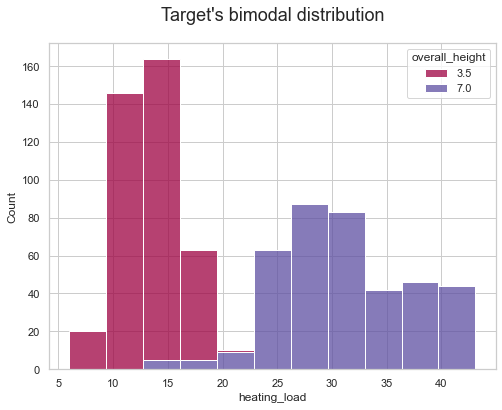

In [17]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(8, 6))
sns.histplot(df, x="heating_load", hue="overall_height", multiple="stack", palette="Spectral")
plt.title("Target's bimodal distribution", y=1.05, size=18);

### Feature importance analysis

#### Correlations between numerical features

Let's visualize the degrees of dependencies between numerical features using a correlation matrix and a heatmap.

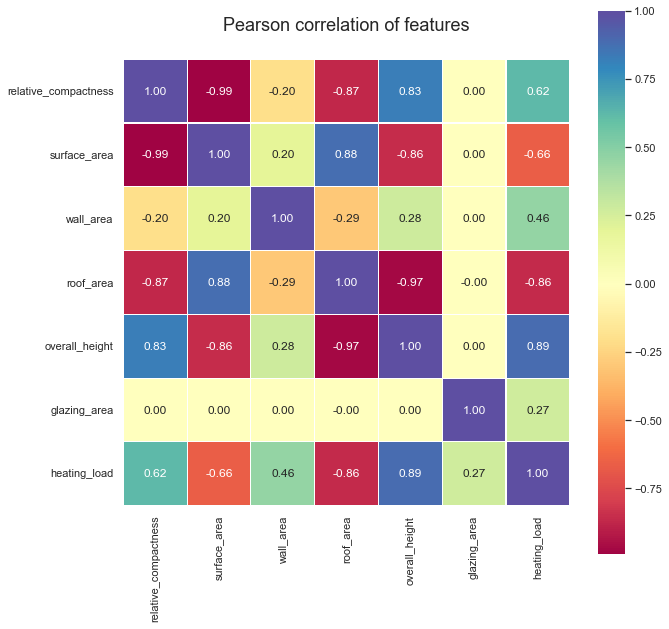

In [18]:
plt.figure(figsize=(10,10))
plt.title("Pearson correlation of features", y=1.05, size=18)
sns.heatmap(df.corr(), center=0, cmap='Spectral', 
            linewidths=0.1, linecolor='white', square=True, 
            annot=True, fmt='.2f');

We can see that the target feature 'heating_load' has strong positive correlation with 'overall_height' and has strong negative correlation with 'roof_area'. Indeed, 'overall_height' and 'roof_area' have strong mutual correlation.

#### Mutual information for categorical features

Let's calculate mutual information - a measure of importance of categorical features for the target feature.

In [19]:
def mutual_info_heating_score(series):
    return mutual_info_score(series, df.heating_load)

In [20]:
mi = df[categorical].apply(mutual_info_heating_score)
mi.sort_values(ascending=False).round(4).to_frame(name='Mutual information')

,Mutual information
glazing_area_distribution,1.4805
orientation,1.1259


We conclude, that among categorical features 'glazing_area_distribution' feature is more important for the target feature 'heating_load'.

# Model training
We will train and tune the following models:

- Ridge regression
    - Ridge `alpha` parameter tuning
- Decision Tree
    - DecisionTreeRegressor `max_depth` parameter tuning
    - DecisionTreeRegressor `min_samples_leaf` parameter tuning
- Random Forest
    - RandomForestRegressor `max_depth` parameter tuning
    - RandomForestRegressor `min_samples_leaf` parameter tuning
    - RandomForestRegressor `max_features` parameter tuning
- XGBoost
    - XGBoost `eta` parameter tuning
    - XGBoost `max_depth` parameter tuning
    - XGBoost `min_child_weight` parameter tuning

## Splitting the dataset

In [21]:
def split_train_val_test(df, val_size, test_size, target, random_state):
    """
    Splits the dataset into 3 parts: train/validation/test with 
    (1-val_size-test_size)/val_size/test_size distribution. 
    Extracts the target variable from all datasets.
    """
    
    # Split the dataset into 2 parts: full_train/test with (train_size+val_size)/test_size distribution
    df_full_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    
    # Split the full_train dataset into 2 parts: train/val with train_size/val_size distribution
    df_train, df_val = train_test_split(df_full_train, test_size=val_size/(1-test_size), random_state=random_state)
    
    # Verify the shapes of datasets
    print(f'train: {df_train.shape}, val: {df_val.shape}, test: {df_test.shape}')
    
    # Reset indices of all datasets 
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    df_full_train = df_full_train.reset_index(drop=True)
    
    # Extract target variable from all datasets 
    y_train = df_train[target].values
    y_val = df_val[target].values
    y_test = df_test[target].values
    y_full_train = df_full_train[target].values

    # Delete target variable from all datasets 
    del df_train[target]
    del df_val[target]
    del df_test[target]
    del df_full_train[target]
    
    return df_full_train, y_full_train, df_train, df_val, df_test, y_train, y_val, y_test

In [22]:
df_full_train, y_full_train, df_train, df_val, df_test, y_train, y_val, y_test =\
            split_train_val_test(df, 0.2, 0.2, 'heating_load', 1)

train: (460, 9), val: (154, 9), test: (154, 9)


In [23]:
# use DictVectorizer to turn train and validation into matrices
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

X_train.shape, X_val.shape

((460, 16), (154, 16))

As we observe above, the ranges of the features are very different. Therefore, we apply a min–max normalization to remove outliers and normalize the data.

In [24]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

## Ridge regression

Ridge regression is a linear least squares model with l2 regularization.

We will tune the Ridge-model with `alpha` in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100].

As the model's score we will take the root mean squared error (RMSE).

### Ridge regression `alpha` parameter tuning

In [25]:
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

scores = []

for a in alphas:
    model = Ridge(alpha=a)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    rmse = np.sqrt(mean_squared_error(y_pred, y_val))
    scores.append(rmse)

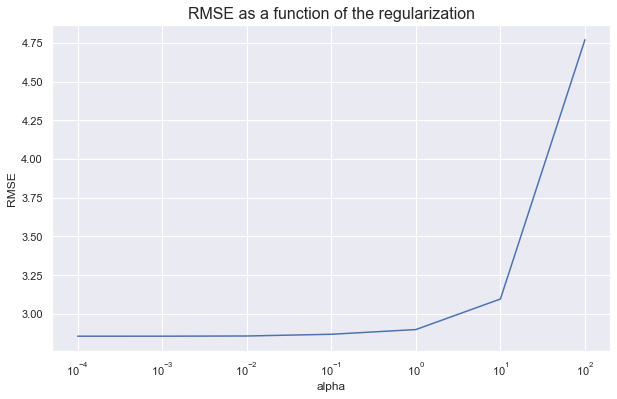

In [26]:
sns.set_theme(style="darkgrid")
f, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=alphas, y=scores, ax=ax)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("RMSE")
plt.title("RMSE as a function of the regularization", size=16);

Let's draw more detailed plot at alpha=0.001:

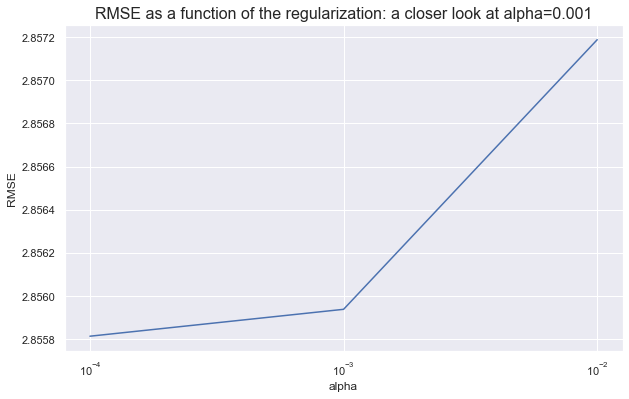

In [27]:
f, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=alphas[:3], y=scores[:3], ax=ax)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("RMSE")
plt.title("RMSE as a function of the regularization: a closer look at alpha=0.001", size=16);

Thus, the best linear Ridge regression model has parameter `alpha` = **0.001**.

## Decision Tree

###  DecisionTreeRegressor `max_depth` parameter tuning

In [28]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, 25, None]

scores = []

for depth in depths: 
    model = DecisionTreeRegressor(max_depth=depth)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    rmse = np.sqrt(mean_squared_error(y_pred, y_val))
    scores.append((depth, rmse))

In [29]:
df_scores = pd.DataFrame(scores, columns=['depth', 'rmse'])
df_scores

,depth,rmse
0,1.0,4.740100
1,2.0,3.432630
2,3.0,2.437353
3,4.0,1.635638
4,5.0,1.106030
5,6.0,0.552972
6,10.0,0.572298
7,15.0,0.586014
8,20.0,0.591273
9,25.0,0.582332


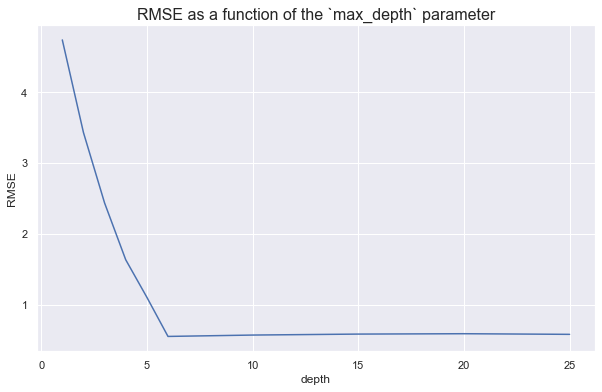

In [30]:
f, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=depths, y=df_scores.rmse, ax=ax)
plt.xlabel("depth")
plt.ylabel("RMSE")
plt.title("RMSE as a function of the `max_depth` parameter", size=16);

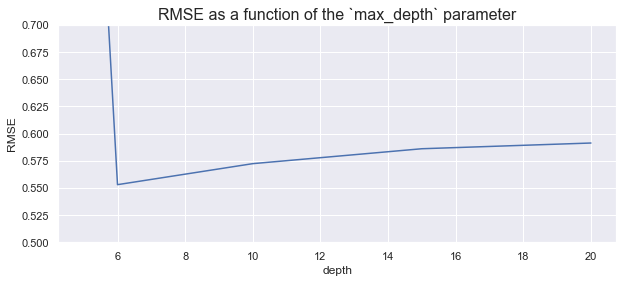

In [31]:
f, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(x=depths[4:9], y=df_scores.rmse[4:9], ax=ax)
plt.ylim(0.5, 0.7)
plt.xlabel("depth")
plt.ylabel("RMSE")
plt.title("RMSE as a function of the `max_depth` parameter", size=16);

We can see that better models have `max_depth` from 6 to 9.

###  DecisionTreeRegressor `min_samples_leaf` parameter tuning

In [32]:
scores = []

for d in [6, 7, 8, 9]:
    for s in [1, 2, 3, 4, 5, 6, 10, 20]:
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=s)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        
        rmse = np.sqrt(mean_squared_error(y_pred, y_val))
        scores.append((d, s, rmse))

In [33]:
columns = ['max_depth', 'min_samples_leaf', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

In [34]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['rmse'])
df_scores_pivot.round(3)

rmse                     
max_depth             6      7      8      9
min_samples_leaf                            
1                 0.549  0.467  0.542  0.546
2                 0.590  0.513  0.528  0.547
3                 0.646  0.556  0.552  0.554
4                 0.693  0.615  0.612  0.613
5                 0.888  0.828  0.824  0.823
6                 0.953  0.896  0.893  0.892
10                1.430  1.414  1.414  1.414
20                2.036  2.036  2.036  2.036

We can see that the best model has `max_depth` = **7** and `min_samples_leaf` = **1**.

## Random Forest

###  RandomForestRegressor `max_depth` parameter tuning

In [35]:
depths = range(10, 51, 5)
trees = range(10, 201, 10)

scores = []

for d in depths:
    for n in trees:
        model = RandomForestRegressor(n_estimators=n,
                                      max_depth=d,
                                      random_state=1, 
                                      n_jobs=-1)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)    
        
        rmse = np.sqrt(mean_squared_error(y_pred, y_val))
        scores.append((d, n, rmse))

In [36]:
columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

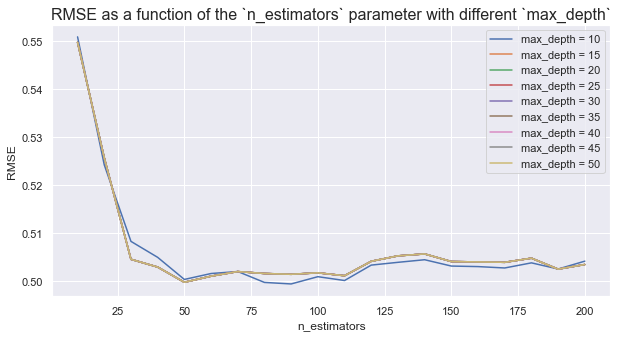

In [37]:
fig = plt.figure(figsize=(10,5))
for d in depths:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=f'max_depth = {d}')
    
plt.legend(loc='upper right')
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.title('RMSE as a function of the `n_estimators` parameter with different `max_depth`', size=16);

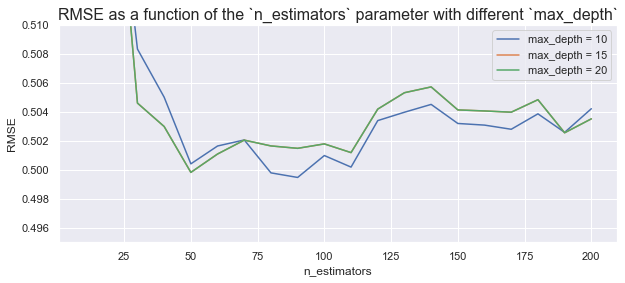

In [38]:
fig = plt.figure(figsize=(10,4))
for d in [10, 15, 20]:
    df_subset = df_scores[df_scores.max_depth == d]

    plt.plot(df_subset.n_estimators, df_subset.rmse, label=f'max_depth = {d}')

plt.ylim(0.495, 0.51)
plt.legend(loc='upper right')
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.title('RMSE as a function of the `n_estimators` parameter with different `max_depth`', size=16);

We observe that `max_depth` = 10 gives the best performance compared to the other values.

In [39]:
max_depth = 10

###  RandomForestRegressor `min_samples_leaf` parameter tuning

In [40]:
scores = []
leaves = [1, 3, 5, 10, 50]
trees = range(10, 201, 10)

for s in leaves:
    for n in trees:
        model = RandomForestRegressor(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1, 
                                    n_jobs=-1)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        
        rmse = np.sqrt(mean_squared_error(y_pred, y_val))
        scores.append((s, n, rmse))

In [41]:
columns = ['min_samples_leaf', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

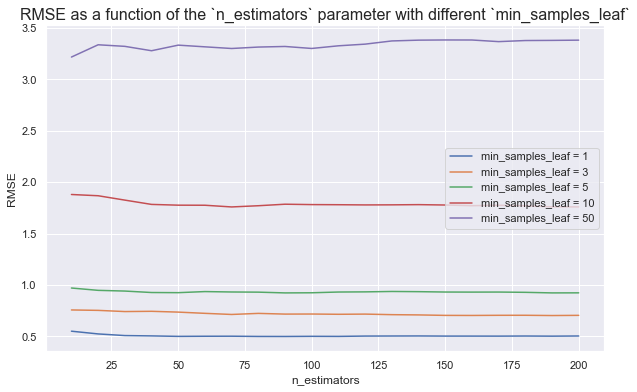

In [42]:
fig = plt.figure(figsize=(10,6))
for s in leaves:
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=f'min_samples_leaf = {s}')
    
plt.legend(loc='right')
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.title('RMSE as a function of the `n_estimators` parameter with different `min_samples_leaf`', size=16);

Our model has the best perfomance with `min_samples_leaf` = **1**.

In [43]:
min_samples_leaf = 1

###  RandomForestRegressor `max_features` parameter tuning

In [44]:
max_feat = [1, 2, 3, 4, 5]
trees = range(10, 201, 10)

scores = []

for mf in max_feat:
    for n in trees:
        model = RandomForestRegressor(n_estimators=n,
                                      max_depth=max_depth,
                                      min_samples_leaf=min_samples_leaf,
                                      max_features=mf,
                                      random_state=1, 
                                      n_jobs=-1)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)    
        
        rmse = np.sqrt(mean_squared_error(y_pred, y_val))
        scores.append((mf, n, rmse))

In [45]:
columns = ['max_features', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

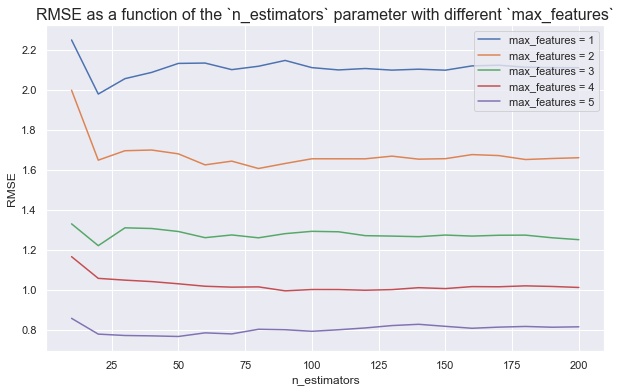

In [46]:
fig = plt.figure(figsize=(10,6))
for mf in max_feat:
    df_subset = df_scores[df_scores.max_features == mf]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=f'max_features = {mf}')
    
plt.legend(loc='upper right')
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.title('RMSE as a function of the `n_estimators` parameter with different `max_features`', size=16);

Our model has the best perfomance with `max_features` = **5**.

## XGBoost

In [47]:
features = dv.feature_names_
features

['glazing_area',
 'glazing_area_distribution=east',
 'glazing_area_distribution=no_glasing',
 'glazing_area_distribution=north',
 'glazing_area_distribution=south',
 'glazing_area_distribution=uniform',
 'glazing_area_distribution=west',
 'orientation=east',
 'orientation=north',
 'orientation=south',
 'orientation=west',
 'overall_height',
 'relative_compactness',
 'roof_area',
 'surface_area',
 'wall_area']

In [48]:
# Create DMatrix for train and validation
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [49]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

###  XGBoost `eta` parameter tuning

We will tune the xgb-model with `eta` in [0.05, 0.1, 0.3]

In [50]:
# Create a watchlist
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [51]:
scores = {}

In [52]:
%%capture output 

xgb_params = {
    'eta': 0.05, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, 
                  num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [53]:
key = f"eta={xgb_params['eta']}"
scores[key] = parse_xgb_output(output)
scores.keys()

dict_keys(['eta=0.05'])

In [54]:
%%capture output 

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, 
                  num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [55]:
key = f"eta={xgb_params['eta']}"
scores[key] = parse_xgb_output(output)
scores.keys()

dict_keys(['eta=0.05', 'eta=0.1'])

In [56]:
%%capture output 

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, 
                  num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [57]:
key = f"eta={xgb_params['eta']}"
scores[key] = parse_xgb_output(output)
scores.keys()

dict_keys(['eta=0.05', 'eta=0.1', 'eta=0.3'])

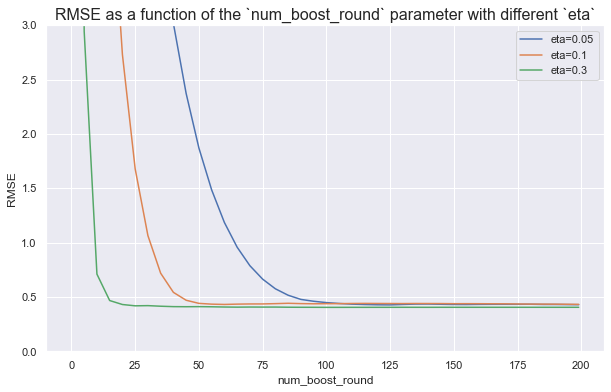

In [58]:
fig = plt.figure(figsize=(10,6))
for eta, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=eta)
    
plt.ylim(0, 3)

plt.legend()
plt.xlabel('num_boost_round')
plt.ylabel('RMSE')
plt.title('RMSE as a function of the `num_boost_round` parameter with different `eta`', size=16);

`eta` = 0.3 has the best score on the validation set.

###  XGBoost `max_depth` parameter tuning

We will tune the xgb-model with `max_depth` in [3, 6, 10].

In [59]:
scores_md = {}

In [60]:
%%capture output 

xgb_params = {
    'eta': 0.3, 
    'max_depth': 3,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, 
                  num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [61]:
key = f"max_depth={xgb_params['max_depth']}"
scores_md[key] = parse_xgb_output(output)
scores_md.keys()

dict_keys(['max_depth=3'])

In [62]:
%%capture output 

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, 
                  num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [63]:
key = f"max_depth={xgb_params['max_depth']}"
scores_md[key] = parse_xgb_output(output)
scores_md.keys()

dict_keys(['max_depth=3', 'max_depth=6'])

In [64]:
%%capture output 

xgb_params = {
    'eta': 0.3, 
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, 
                  num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [65]:
key = f"max_depth={xgb_params['max_depth']}"
scores_md[key] = parse_xgb_output(output)
scores_md.keys()

dict_keys(['max_depth=3', 'max_depth=6', 'max_depth=10'])

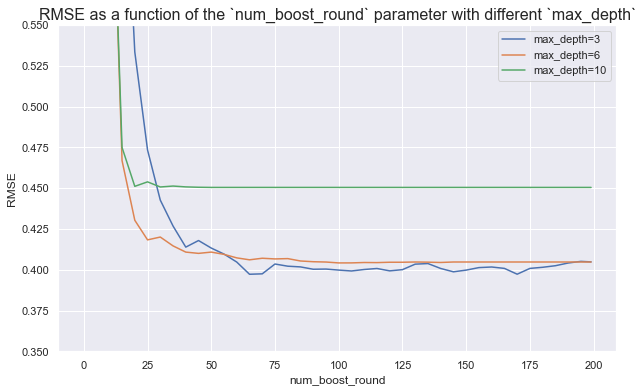

In [66]:
fig = plt.figure(figsize=(10,6))
for max_depth, df_score in scores_md.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=max_depth)
    
plt.ylim(0.35, 0.55)

plt.legend()
plt.xlabel('num_boost_round')
plt.ylabel('RMSE')
plt.title('RMSE as a function of the `num_boost_round` parameter with different `max_depth`', size=16);

`max_depth` = 3 has the best score on the validation set.

###  XGBoost `min_child_weight` parameter tuning

We will tune the xgb-model with `min_child_weight` in [1, 3, 5, 10]

In [67]:
scores_mcw = {}

In [68]:
%%capture output 

xgb_params = {
    'eta': 0.3, 
    'max_depth': 3,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, 
                  num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [69]:
key = f"min_child_weight={xgb_params['min_child_weight']}"
scores_mcw[key] = parse_xgb_output(output)
scores_mcw.keys()

dict_keys(['min_child_weight=1'])

In [70]:
%%capture output 

xgb_params = {
    'eta': 0.3, 
    'max_depth': 3,
    'min_child_weight': 3,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, 
                  num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [71]:
key = f"min_child_weight={xgb_params['min_child_weight']}"
scores_mcw[key] = parse_xgb_output(output)
scores_mcw.keys()

dict_keys(['min_child_weight=1', 'min_child_weight=3'])

In [72]:
%%capture output 

xgb_params = {
    'eta': 0.3, 
    'max_depth': 3,
    'min_child_weight': 5,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, 
                  num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [73]:
key = f"min_child_weight={xgb_params['min_child_weight']}"
scores_mcw[key] = parse_xgb_output(output)
scores_mcw.keys()

dict_keys(['min_child_weight=1', 'min_child_weight=3', 'min_child_weight=5'])

In [74]:
%%capture output 

xgb_params = {
    'eta': 0.3, 
    'max_depth': 3,
    'min_child_weight': 10,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, 
                  num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [75]:
key = f"min_child_weight={xgb_params['min_child_weight']}"
scores_mcw[key] = parse_xgb_output(output)
scores_mcw.keys()

dict_keys(['min_child_weight=1', 'min_child_weight=3', 'min_child_weight=5', 'min_child_weight=10'])

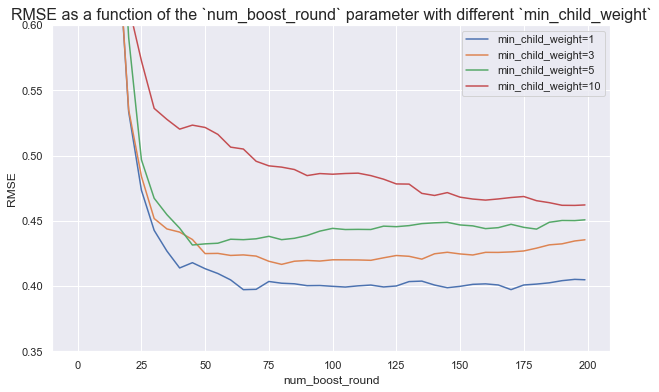

In [76]:
fig = plt.figure(figsize=(10,6))
for min_child_weight, df_score in scores_mcw.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=min_child_weight)
    
plt.ylim(0.35, 0.6)

plt.legend()
plt.xlabel('num_boost_round')
plt.ylabel('RMSE')
plt.title('RMSE as a function of the `num_boost_round` parameter with different `min_child_weight`', size=16);

`min_child_weight` = 1 has the best score on the validation set.

# Selecting the final model

Let's gather all the models with their best hyperparameters, which were considered above, and calculate RMSE on train and validation sets. 

In [77]:
best_models = {'Ridge Regression': Ridge(alpha=0.001),
          'DecisionTreeRegressor': DecisionTreeRegressor(max_depth=7, min_samples_leaf=1),
          'RandomForestRegressor': RandomForestRegressor(
                                    n_estimators=50,
                                    max_depth=10,
                                    min_samples_leaf=1,
                                    max_features=5,
                                    random_state=1),
                        'XGBoost': {
                                        'eta': 0.3, 
                                        'max_depth': 3,
                                        'min_child_weight': 1,

                                        'objective': 'reg:squarederror',
                                        'eval_metric': 'rmse',
                                        'nthread': 8,

                                        'seed': 1,
                                        'verbosity': 1,
                                    }
    
              }

In [78]:
rmse_score = []

for name, model in best_models.items():
    if name != 'XGBoost':
        model.fit(X_train, y_train)
        rmse_train = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))
        rmse_val = np.sqrt(mean_squared_error(y_val, model.predict(X_val)))
    else:
        xgb_params = model                 
        model = xgb.train(xgb_params, dtrain, 
                  num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)
        rmse_train = np.sqrt(mean_squared_error(y_train, model.predict(dtrain)))
        rmse_val = np.sqrt(mean_squared_error(y_val, model.predict(dval)))

    rmse_score.append((name, rmse_train.round(3), rmse_val.round(3)));

[0]	train-rmse:16.96432	val-rmse:16.31287
[5]	train-rmse:3.34130	val-rmse:3.00963
[10]	train-rmse:1.17250	val-rmse:1.16773
[15]	train-rmse:0.64309	val-rmse:0.68798
[20]	train-rmse:0.50055	val-rmse:0.53356
[25]	train-rmse:0.45020	val-rmse:0.47347
[30]	train-rmse:0.42191	val-rmse:0.44271
[35]	train-rmse:0.40265	val-rmse:0.42683
[40]	train-rmse:0.38778	val-rmse:0.41388
[45]	train-rmse:0.37438	val-rmse:0.41792
[50]	train-rmse:0.36568	val-rmse:0.41330
[55]	train-rmse:0.35557	val-rmse:0.40962
[60]	train-rmse:0.34638	val-rmse:0.40472
[65]	train-rmse:0.33892	val-rmse:0.39724
[70]	train-rmse:0.33464	val-rmse:0.39750
[75]	train-rmse:0.32907	val-rmse:0.40352
[80]	train-rmse:0.32462	val-rmse:0.40219
[85]	train-rmse:0.31876	val-rmse:0.40175
[90]	train-rmse:0.31127	val-rmse:0.40032
[95]	train-rmse:0.30593	val-rmse:0.40043
[100]	train-rmse:0.30240	val-rmse:0.39980
[105]	train-rmse:0.29886	val-rmse:0.39925
[110]	train-rmse:0.29655	val-rmse:0.40017
[115]	train-rmse:0.29250	val-rmse:0.40078
[120]	train-

In [79]:
columns = ['model', 'rmse_train', 'rmse_val']
df_scores = pd.DataFrame(rmse_score, columns=columns).set_index('model')
df_scores

,rmse_train,rmse_val
model,,
Ridge Regression,2.652,2.856
DecisionTreeRegressor,0.334,0.470
RandomForestRegressor,0.362,0.768
XGBoost,0.252,0.405


Based on the values of the RMSE scores on validation dataset we conclude that 'XGBoost' is the best final model.

In [80]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
    }

model = xgb.train(xgb_params, dtrain, num_boost_round=200)

In [81]:
y_pred = model.predict(dval)
rmse = np.sqrt(mean_squared_error(y_pred, y_val))
print(f'RMSE on validation dataset is {rmse.round(3)}.')

RMSE on validation dataset is 0.405.


# Train the final model

In [82]:
df_full_train.shape, y_full_train.shape

((614, 8), (614,))

In [83]:
# use DictVectorizer to turn full_train and test into matrices
dv = DictVectorizer(sparse=False)

full_train_dict = df_full_train.to_dict(orient='records')
X_full_train = dv.fit_transform(full_train_dict)

test_dict = df_test.to_dict(orient='records')
X_test = dv.transform(test_dict)

X_full_train.shape, X_test.shape

((614, 16), (154, 16))

In [84]:
# Create DMatrix for full_train and test
features = dv.feature_names_
dfull_train = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

In [85]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
    }

model_final = xgb.train(xgb_params, dfull_train, num_boost_round=200)

In [86]:
y_pred = model_final.predict(dtest)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred)).round(3)

print(f'Final model: XGBoost(eta=0.3, max_depth=3, min_child_weight=1)')
print(f'Final model RMSE on test dataset: {rmse_test.round(3)}')

Final model: XGBoost(eta=0.3, max_depth=3, min_child_weight=1)
Final model RMSE on test dataset: 0.394
